In [217]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn_evaluation import plot
from sklearn.svm import SVR

from sklearn.tree import DecisionTreeRegressor

In [218]:
train_data_path = "train_dummy.csv"
test_data_path = "test_dummy.csv"

In [219]:
train_data = pd.read_csv(train_data_path, low_memory=False)
test_data = pd.read_csv(test_data_path, low_memory=False)

In [220]:
train_data.dtypes

MSSubClass                 int64
LotFrontage              float64
LotArea                    int64
OverallCond                int64
YearBuilt                  int64
                          ...   
SaleCondition_AdjLand      int64
SaleCondition_Alloca       int64
SaleCondition_Family       int64
SaleCondition_Normal       int64
SaleCondition_Partial      int64
Length: 256, dtype: object

In [221]:
#Scaling
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_train_data = pd.DataFrame(scaled_train, columns=train_data.columns)
scaled_test = scaler.transform(test_data)
scaled_test_data = pd.DataFrame(scaled_test,columns=test_data.columns)

In [222]:
#Vypisanie najviac korelujucich hodnot
corr = train_data.corr().abs()
highest_corr = corr.unstack()
sorted_highest_corr = highest_corr.sort_values(ascending=False).drop_duplicates()
sorted_highest_corr

CentralAir_Y         CentralAir_N             1.000000e+00
MSSubClass           MSSubClass               1.000000e+00
Street_Grvl          Street_Pave              1.000000e+00
SaleType_New         SaleCondition_Partial    9.883582e-01
Exterior2nd_VinylSd  Exterior1st_VinylSd      9.799339e-01
                                                  ...     
MasVnrType_None      Exterior1st_Plywood      3.887687e-05
HeatingQC_TA         LandSlope_Mod            2.621237e-05
BsmtFinType1_Rec     Exterior1st_HdBoard      2.183901e-05
Exterior2nd_AsbShng  GrLivArea                1.380617e-05
SaleType_New         GarageQual_Gd            2.729716e-17
Length: 27049, dtype: float64

In [223]:
fig = px.imshow(corr)
#fig.show()
fig.write_html("corr_matrix.html")

In [224]:
X = scaled_train_data.drop('SalePrice', axis=1)
y = scaled_train_data['SalePrice']

In [225]:
print(np.shape(X))
print(np.shape(y))

(940, 255)
(940,)


In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

In [227]:
param_grid = {'max_features': ['sqrt', 'log2',1.0],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['squared_error', 'absolute_error'],
              'min_samples_leaf': [1,2,3,4]
             }

In [228]:
regressor = DecisionTreeRegressor()
grid_search = GridSearchCV(estimator=regressor,
                           param_grid=param_grid,
                           scoring=["r2","mean_squared_error"],
                           refit="r2",
                           cv=5, verbose=4)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV 1/5] END ccp_alpha=0.1, criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1; neg_root_mean_squared_error: (test=-0.117) r2: (test=-0.000) total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1; neg_root_mean_squared_error: (test=-0.115) r2: (test=-0.009) total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1; neg_root_mean_squared_error: (test=-0.104) r2: (test=-0.008) total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1; neg_root_mean_squared_error: (test=-0.094) r2: (test=-0.001) total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1; neg_root_mean_squared_error: (test=-0.156) r2: (test=-0.019) total time=   0.0s
[CV 1/5] EN

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [5, 6, 7, 8, 9],
                         'max_features': ['sqrt', 'log2', 1.0],
                         'min_samples_leaf': [1, 2, 3, 4]},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'],
             verbose=4)

In [229]:
print("BEST ESTIMATOR: " + str(grid_search.best_estimator_))
print("BEST SCORE: " + str(grid_search.best_score_))

BEST ESTIMATOR: DecisionTreeRegressor(ccp_alpha=0.001, criterion='absolute_error', max_depth=5,
                      max_features=1.0)
BEST SCORE: 0.6338526236113838


In [280]:
tree_results = pd.DataFrame(grid_search.cv_results_)
tree_results = tree_results.sort_values("rank_test_r2")
tree_results.to_csv("tree_results.csv")

In [231]:
estimator = DecisionTreeRegressor(ccp_alpha=0.001, criterion='absolute_error', max_depth=5,min_samples_leaf=2)
estimator.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.001, criterion='absolute_error', max_depth=5,
                      min_samples_leaf=2)

<AxesSubplot: title={'center': 'Residuals Plot'}, xlabel='Predicted Value', ylabel='Residuals'>

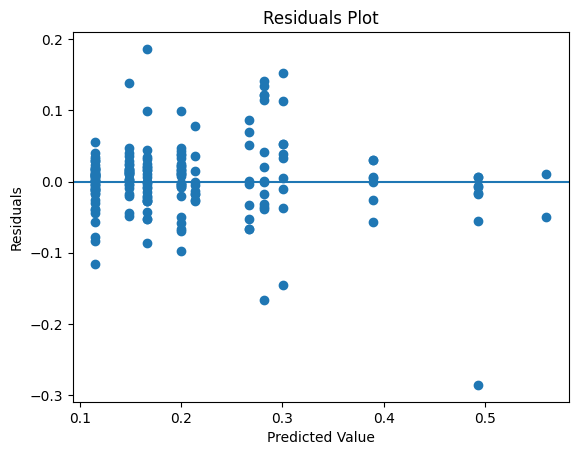

In [278]:
y_pred = estimator.predict(X_test)
y_true = y_test
plot.residuals(y_true, y_pred)

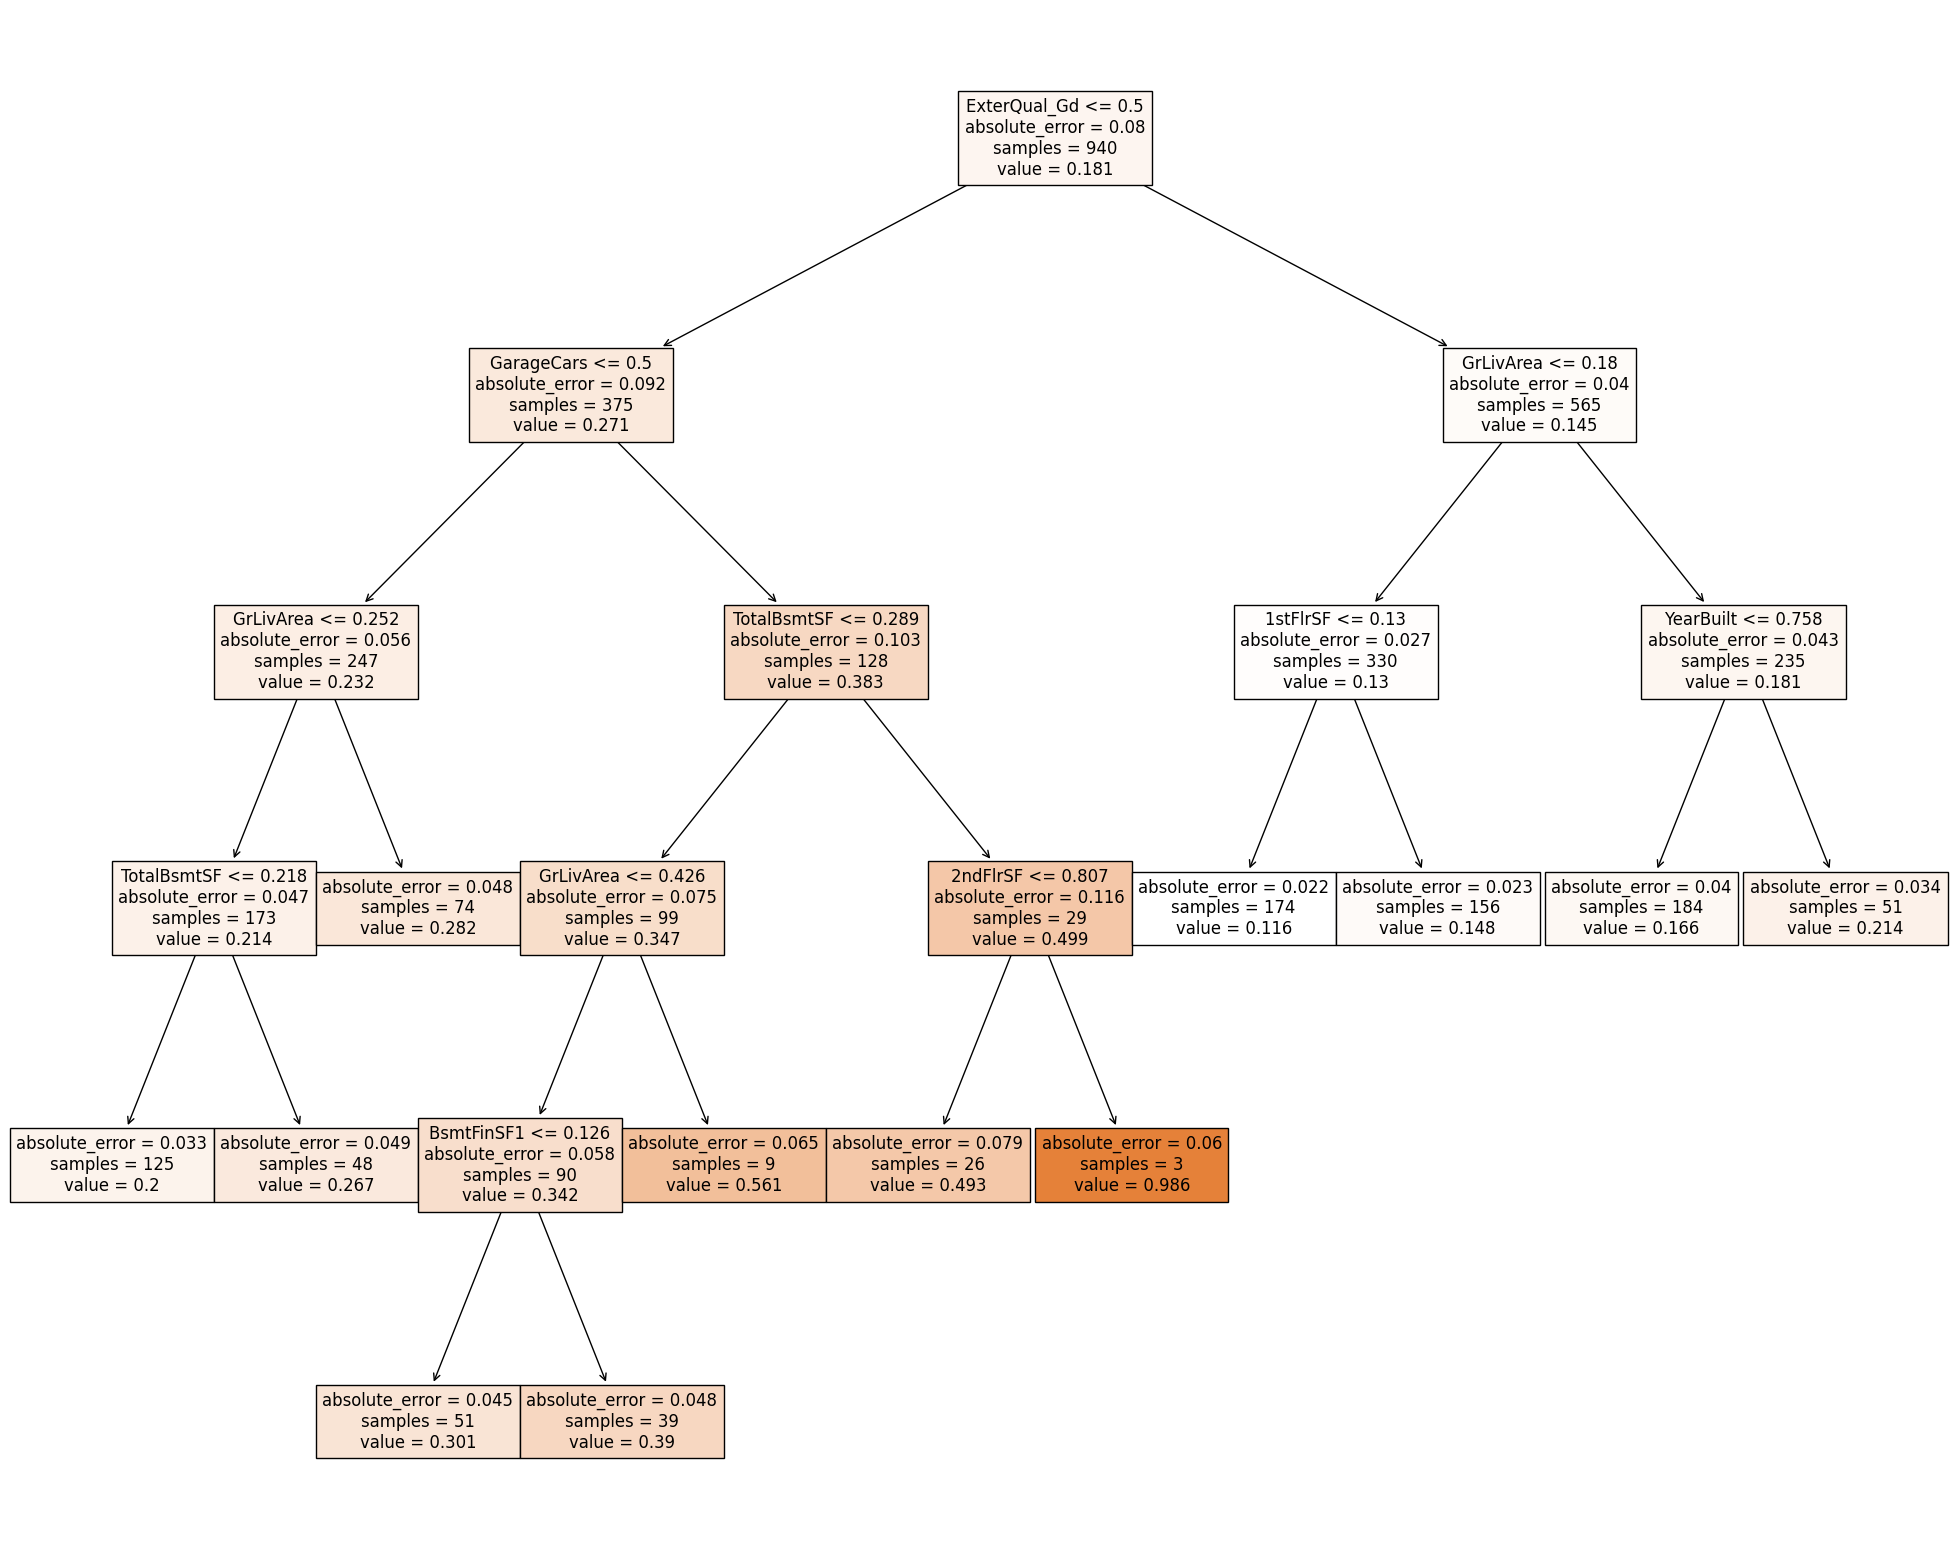

In [232]:
text_representation = tree.export_text(estimator)
feature_names = list(scaled_train_data.columns.values)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(estimator,feature_names= feature_names,
                   filled=True)
fig.savefig('decisionTree.png')

In [308]:
param = {'kernel' : ('linear', 'poly', 'rbf'),'C' : [1,5,10],'gamma' : (0.1,0.01,0.001)},

svrGridSearch = GridSearchCV(estimator=SVR(),param_grid=param,
                             cv=5,
                             verbose=4,)

svrGridSearch.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END .....C=1, gamma=0.1, kernel=linear;, score=0.671 total time=   0.0s
[CV 2/5] END .....C=1, gamma=0.1, kernel=linear;, score=0.411 total time=   0.0s
[CV 3/5] END .....C=1, gamma=0.1, kernel=linear;, score=0.674 total time=   0.0s
[CV 4/5] END .....C=1, gamma=0.1, kernel=linear;, score=0.574 total time=   0.0s
[CV 5/5] END .....C=1, gamma=0.1, kernel=linear;, score=0.732 total time=   0.0s
[CV 1/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.691 total time=   0.0s
[CV 2/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.517 total time=   0.0s
[CV 3/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.717 total time=   0.0s
[CV 4/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.670 total time=   0.0s
[CV 5/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.698 total time=   0.0s
[CV 1/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.462 total time=   0.0s
[CV 2/5] END ........C=1, gamma=0.1, kernel=rbf

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=({'C': [1, 5, 10], 'gamma': (0.1, 0.01, 0.001),
                          'kernel': ('linear', 'poly', 'rbf')},),
             verbose=4)

In [312]:
grid_scores = svrGridSearch.cv_results_
tree_results = pd.DataFrame(grid_scores)
#tree_results = tree_results.sort_values("rank_test_r2")
tree_results.to_csv("svm_results.csv")

In [313]:
print("BEST ESTIMATOR: " + str(svrGridSearch.best_estimator_))
print("BEST SCORE: " + str(svrGridSearch.best_score_))
print("BEST PARAMETERS" + str(svrGridSearch.best_params_))

BEST ESTIMATOR: SVR(C=5, gamma=0.001)
BEST SCORE: 0.6898709392759999
BEST PARAMETERS{'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}


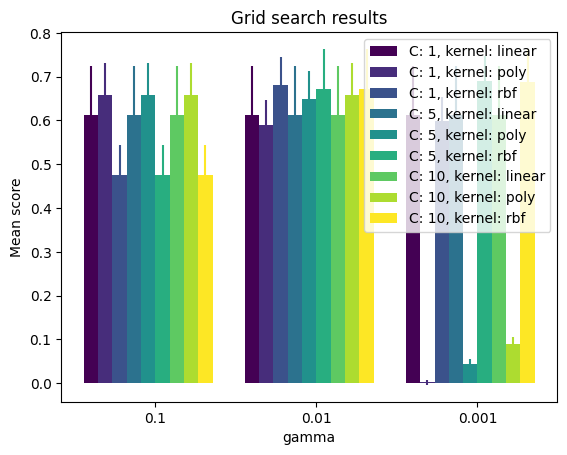

In [314]:
svrGridSearchResults = svrGridSearch.cv_results_
ax = plot.grid_search(svrGridSearch.cv_results_, change="gamma", kind='bar', sort=False)

In [289]:
from sklearn_evaluation import plot
bestSvr = SVR(C=1,gamma='auto',kernel='rbf', verbose=True)
bestSvr.fit(X_train,y_train)

[LibSVM]

SVR(C=1, gamma='auto', verbose=True)

<AxesSubplot: title={'center': 'Residuals Plot'}, xlabel='Predicted Value', ylabel='Residuals'>

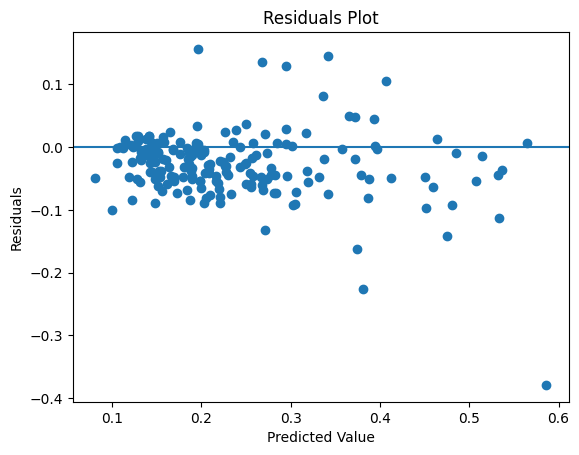

In [290]:
y_pred = bestSvr.predict(X_test)
y_true = y_test
plot.residuals(y_true, y_pred)